## Machine Learning and Pattern Recognition
## Excercise 2 
## Jeba Akewak 
## ID - 41913


## Goal

In this exercise we are developing and evaluating a deep learning model for one of the most important problems of
visual recognition- image classification. For models, Convolution Neural Networks (CNNs) have
been successfully used in a variety of computer vision tasks. This type of projects would involve
understanding the state-of-the-art vision models, and building a CNN model


## Tools 

The tools used for this exercise is Keras, Tensorflow

## Dataset

The extended Yale Face Database B (same dataset in Exercise1).
The data set consists of face image of 38 different persons, each photographed in several conditions:
– Intensity of illumination
– Position of light source
– But only one pose, unlike in the original non-cropped database
All test image data used in this exercise are aligned, cropped, and then re-sized to 168x192 images.

The dataset is available in http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html ->
(cropped Images)
OR
try https://seafile.utu.fi/f/2d94c45d1c214f4da640/.


## Tasks


1.We asked to create a CNN model with the following architecture:

Conv layer 1:
- Filter size = 5
- Number of filters = 16
- Activation function = relu

Pooling layer 1:
- max pooling = 2

Conv layer 2:
- Filter size = 5
- Number of filters = 36
- Activation function = relu

Pooling layer 2:
- max pooling = 2
Fully connected layer 1:
- Number of neurons: 512
- Activation function = relu

Fully connected layer 2:
- Number of neurons: number_Of_Classes
- Activation function = softmax

Regularisation: dropout (prob = 0.5)


First we import all the necessary libraries 

In [1]:
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
from orderedset import OrderedSet
import imageio
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder
import os
os.getcwd()#check the working dir

'/Users/akewakjeba'

Next all the helper fuctions to change the given pic's pixel values to pandas data frame

All the credit goes to the writer of the code below, it simplifies the exercise at a great extent.

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 12 21:14:39 2018

@author: mika

This file contains an example implementation of how the images can be read
in python.

I give no guarantees of the implementation working properly.
"""
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
import imageio
from orderedset import OrderedSet

def get_croppedyale_as_df():
    """ Get a subset of the cropped Yale images as one 2D array (Pandas DataFrame).

    All 'Ambient' images are discarded. Also, if there are persons that have not
    been photographed in certain illumination conditions, none of the images taken
    in those conditions are included in the result.

    Each row of the output table (Pandas data frame) contains one image represented
    as a linear array.
    """
    pics, all_suffixes, suffixes = load_images_croppedyale()
    feature_matrix, person_names, full_names, resolution = images_to_array(pics, suffixes)
    name_suffixes = [full_name[1] for full_name in full_names]
    feature_matrix = pd.DataFrame(feature_matrix)
    feature_matrix.loc[:, 'person'] = person_names
    feature_matrix.loc[:, 'pic_name'] = name_suffixes
    feature_matrix = feature_matrix.set_index(['person', 'pic_name'])
    return feature_matrix, resolution

def load_images_croppedyale():
    """ Read images from the cropped Yale data set.

    The implementation is heavily tied to the known directory structure of the data set.
    Also, pictures labeled 'Ambient' are discarded because some of them have not been
    cropped and are not the same size as the other images.

    Returns:
    1) The loaded pictures as an ordered dictionary of ordered dictionaries.
    The keys of the first-level dictionary are folder names such as 'yaleB10', each name
    corresponding to one person. In the second-level dictionaries the keys are strings
    describing the pose and the illumination, as extracted from the file names.
    2) All keys appearing in any of the second-level dictionaries, as an OrderedSet.
    3) All keys appearing in all second-level dictionaries, as an OrderedSet.
    """
    orig_folder = os.getcwd()
    try:
        os.chdir('/Users/akewakjeba/desktop/CroppedYale_')
        subdirs = sorted(os.listdir())
        pics = OrderedDict()
        u_fname_suffixes, i_fname_suffixes = OrderedSet(), OrderedSet()
        image_resolution = None
        first_iter = True
        for subdir in subdirs: # Iterate over all folders (persons)
            pics[subdir] = OrderedDict()
            os.chdir(subdir)
            file_names = [x for x in os.listdir() if x.endswith('.pgm') and 'Ambient' not in x]
            current_suffixes = sorted(x[len(subdir) + 1 : -4] for x in file_names)
            for fname_suffix in current_suffixes: # Iterate over files (images)
                fname = subdir + '_' + fname_suffix + '.pgm'
                pic = imageio.imread(fname)
                pics[subdir][fname_suffix] = pic
                if image_resolution is None:
                    image_resolution = [len(pic[0]), len(pic)]
                elif image_resolution != [len(pic[0]), len(pic)]:
                    print('Warning: input images have different sizes.')
            u_fname_suffixes = u_fname_suffixes.union(current_suffixes)
            if first_iter:
                i_fname_suffixes, first_iter = u_fname_suffixes, False
            else:
                i_fname_suffixes = i_fname_suffixes.intersection(current_suffixes)
            os.chdir('..')
        return pics, u_fname_suffixes, i_fname_suffixes
    finally:
        os.chdir(orig_folder)

def images_to_array(pics, included_suffixes):
    """ Convert the given pictures to a numpy array.

    Each row of the returned array is a linear representation of one image.
    Pictures whose properties do not match any of included_suffixes are not included.
    It is also checked that all images have the same resolution - if not, an
    Exception is raised.

    In addition to the array of pictures, also a list of all labels (person
    'names') and suffixes (lighting conditions) is returned, as well as the
    resolution of the images.
    """
    x_res, y_res = -1, -1
    feature_matrix = None
    person_names = []
    full_pic_names = []
    # Get the resolution and the names of the included pictures. For
    # better performance we defer the creation of the feature matrix.
    for person_name in pics.keys():
        for pic_name in included_suffixes:
            current_pic = pics[person_name][pic_name]
            xpix, ypix = len(current_pic[0]), len(current_pic)
            if x_res < 0: # We are processing the first image
                x_res, y_res = xpix, ypix
            else:
                if (x_res, y_res) != (xpix, ypix):
                    raise Exception('All images must be of the same size.')
            person_names += [person_name]
            full_pic_names += [(person_name, pic_name)]
    # Get the pictures into the feature matrix. Pixel intensities are
    # scaled from 0...255 to the range [0, 1].
    pic_arrays = [np.array((pics[s[0]][s[1]] / 255).ravel()) for s in full_pic_names]
    feature_matrix = np.vstack(pic_arrays)
    return feature_matrix, np.array(person_names), np.array(full_pic_names), [x_res, y_res]


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 22:39:40 2018
@author: mika
This is a simple example where we read the images as a DataFrame using
get_croppedyale_as_df() and then select some rows of the DataFrame based
on person 'names' or lighting conditions.
"""
# import read_yale
images, resolution = get_croppedyale_as_df()
# The data frame uses a MultiIndex to store the person 'names' and lighting
# conditions. Here we briefly demonstrate using the data frame.
# Get the names of the persons
row_persons = images.index.get_level_values('person')
# Get all images of 'yaleB10'
# rows_include = (row_persons == 'yaleB10')
# pics_B10 = images[rows_include]
# print(pics_B10) # there are over 30 000 columns so results are not pretty..
# Get all images under conditions "P00A-130E+20"
row_conds = images.index.get_level_values('pic_name')
rows_include = (row_conds == row_conds.all())
pics_2 = images[rows_include]
print(pics_2)

                         0         1         2         3         4      \
person  pic_name                                                         
yaleB01 P00A-130E+20  0.023529  0.027451  0.031373  0.031373  0.023529   
yaleB02 P00A-130E+20  0.023529  0.023529  0.023529  0.027451  0.027451   
yaleB03 P00A-130E+20  0.027451  0.027451  0.031373  0.027451  0.027451   
yaleB04 P00A-130E+20  0.023529  0.023529  0.023529  0.015686  0.015686   
yaleB05 P00A-130E+20  0.000000  0.000000  0.000000  0.003922  0.000000   
yaleB06 P00A-130E+20  0.027451  0.031373  0.031373  0.035294  0.035294   
yaleB07 P00A-130E+20  0.027451  0.027451  0.027451  0.027451  0.031373   
yaleB08 P00A-130E+20  0.011765  0.011765  0.011765  0.015686  0.015686   
yaleB09 P00A-130E+20  0.011765  0.015686  0.019608  0.023529  0.023529   
yaleB10 P00A-130E+20  0.039216  0.039216  0.043137  0.039216  0.035294   
yaleB11 P00A-130E+20  0.039216  0.035294  0.035294  0.039216  0.039216   
yaleB12 P00A-130E+20  0.027451  0.0313

In [4]:
# This will find the rest of the data with the other condition than the above
rows_include_3 = (row_conds != row_conds.all())
pics_3 = images[rows_include_3]
print(pics_3)

                         0         1         2         3         4      \
person  pic_name                                                         
yaleB01 P00A+000E+00  0.313725  0.313725  0.329412  0.352941  0.360784   
        P00A+000E+20  0.368627  0.368627  0.376471  0.400000  0.427451   
        P00A+000E+45  0.231373  0.258824  0.301961  0.337255  0.360784   
        P00A+000E+90  0.062745  0.070588  0.086275  0.090196  0.109804   
        P00A+000E-20  0.270588  0.278431  0.301961  0.309804  0.309804   
        P00A+000E-35  0.207843  0.203922  0.219608  0.227451  0.231373   
        P00A+005E+10  0.415686  0.419608  0.454902  0.482353  0.482353   
        P00A+005E-10  0.368627  0.376471  0.407843  0.411765  0.423529   
        P00A+010E+00  0.466667  0.466667  0.509804  0.529412  0.533333   
        P00A+010E-20  0.352941  0.352941  0.364706  0.380392  0.388235   
        P00A+015E+20  0.466667  0.470588  0.486275  0.513725  0.533333   
        P00A+020E+10  0.482353  0.4862

Find a data frame with all different condition with one condition assign that to pics_2, then find the other conditions for all and assign it to pics_3. Then merge both to get all the data.

38 + 2128 = 2166 (which is 38*57 = 2166). Each person has 57 different kind of pictures!

In [5]:
#Merging those two data frames gives us the whole data set as data frame
frames = [pics_2,pics_3]
result = pd.concat(frames)

In [6]:
result.head()

,,0,1,2,3,4,5,6,7,8,9,...,32246,32247,32248,32249,32250,32251,32252,32253,32254,32255
person,pic_name,,,,,,,,,,,,,,,,,,,,,
yaleB01,P00A-130E+20,0.023529,0.027451,0.031373,0.031373,0.023529,0.023529,0.023529,0.027451,0.023529,0.027451,...,0.211765,0.321569,0.309804,0.156863,0.172549,0.211765,0.184314,0.298039,0.372549,0.458824
yaleB02,P00A-130E+20,0.023529,0.023529,0.023529,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,...,0.058824,0.058824,0.062745,0.058824,0.058824,0.062745,0.066667,0.070588,0.074510,0.078431
yaleB03,P00A-130E+20,0.027451,0.027451,0.031373,0.027451,0.027451,0.027451,0.027451,0.031373,0.027451,0.027451,...,0.125490,0.160784,0.149020,0.160784,0.207843,0.266667,0.317647,0.313725,0.282353,0.278431
yaleB04,P00A-130E+20,0.023529,0.023529,0.023529,0.015686,0.015686,0.019608,0.015686,0.015686,0.015686,0.019608,...,0.215686,0.207843,0.168627,0.188235,0.211765,0.235294,0.282353,0.227451,0.250980,0.274510
yaleB05,P00A-130E+20,0.000000,0.000000,0.000000,0.003922,0.000000,0.003922,0.003922,0.000000,0.000000,0.000000,...,0.741176,0.533333,0.364706,0.407843,0.403922,0.435294,0.494118,0.588235,0.639216,0.674510


In [7]:
result =result.reset_index(level=['person', 'pic_name']) 

In [8]:
result.head()

,person,pic_name,0,1,2,3,4,5,6,7,...,32246,32247,32248,32249,32250,32251,32252,32253,32254,32255
0,yaleB01,P00A-130E+20,0.023529,0.027451,0.031373,0.031373,0.023529,0.023529,0.023529,0.027451,...,0.211765,0.321569,0.309804,0.156863,0.172549,0.211765,0.184314,0.298039,0.372549,0.458824
1,yaleB02,P00A-130E+20,0.023529,0.023529,0.023529,0.027451,0.027451,0.027451,0.027451,0.027451,...,0.058824,0.058824,0.062745,0.058824,0.058824,0.062745,0.066667,0.070588,0.074510,0.078431
2,yaleB03,P00A-130E+20,0.027451,0.027451,0.031373,0.027451,0.027451,0.027451,0.027451,0.031373,...,0.125490,0.160784,0.149020,0.160784,0.207843,0.266667,0.317647,0.313725,0.282353,0.278431
3,yaleB04,P00A-130E+20,0.023529,0.023529,0.023529,0.015686,0.015686,0.019608,0.015686,0.015686,...,0.215686,0.207843,0.168627,0.188235,0.211765,0.235294,0.282353,0.227451,0.250980,0.274510
4,yaleB05,P00A-130E+20,0.000000,0.000000,0.000000,0.003922,0.000000,0.003922,0.003922,0.000000,...,0.741176,0.533333,0.364706,0.407843,0.403922,0.435294,0.494118,0.588235,0.639216,0.674510


In [9]:
len(result)

2166

In [10]:
df_class= result.loc[:,'person' ]
df_features= result.iloc[:, 2: ]

In [11]:
X=df_features
Y=df_class

In [12]:
print(X.shape)
print(Y.shape)

(2166, 32256)
(2166,)


In [13]:
result.describe()

,0,1,2,3,4,5,6,7,8,9,...,32246,32247,32248,32249,32250,32251,32252,32253,32254,32255
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,...,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,0.249932,0.254601,0.258691,0.261871,0.264860,0.268754,0.273161,0.275819,0.276498,0.278900,...,0.193203,0.190899,0.189399,0.188346,0.184902,0.179206,0.171631,0.163563,0.158789,0.156202
std,0.261406,0.262865,0.263218,0.263298,0.262390,0.261540,0.262151,0.262622,0.263197,0.263905,...,0.227824,0.226193,0.225816,0.226058,0.225996,0.223366,0.219382,0.215094,0.214577,0.214613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.019608,0.019608,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,...,0.031373,0.031373,0.031373,0.031373,0.031373,0.027451,0.027451,0.023529,0.023529,0.023529
50%,0.168627,0.180392,0.188235,0.196078,0.203922,0.213725,0.227451,0.231373,0.231373,0.237255,...,0.070588,0.066667,0.066667,0.062745,0.062745,0.058824,0.058824,0.054902,0.050980,0.050980
75%,0.403922,0.415686,0.419608,0.419608,0.423529,0.431373,0.439216,0.443137,0.447059,0.453922,...,0.320588,0.317647,0.309804,0.305882,0.294118,0.282353,0.266667,0.247059,0.227451,0.219608
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
dff=result.iloc[:,2:]
dff.head()

,0,1,2,3,4,5,6,7,8,9,...,32246,32247,32248,32249,32250,32251,32252,32253,32254,32255
0,0.023529,0.027451,0.031373,0.031373,0.023529,0.023529,0.023529,0.027451,0.023529,0.027451,...,0.211765,0.321569,0.309804,0.156863,0.172549,0.211765,0.184314,0.298039,0.372549,0.458824
1,0.023529,0.023529,0.023529,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,...,0.058824,0.058824,0.062745,0.058824,0.058824,0.062745,0.066667,0.070588,0.074510,0.078431
2,0.027451,0.027451,0.031373,0.027451,0.027451,0.027451,0.027451,0.031373,0.027451,0.027451,...,0.125490,0.160784,0.149020,0.160784,0.207843,0.266667,0.317647,0.313725,0.282353,0.278431
3,0.023529,0.023529,0.023529,0.015686,0.015686,0.019608,0.015686,0.015686,0.015686,0.019608,...,0.215686,0.207843,0.168627,0.188235,0.211765,0.235294,0.282353,0.227451,0.250980,0.274510
4,0.000000,0.000000,0.000000,0.003922,0.000000,0.003922,0.003922,0.000000,0.000000,0.000000,...,0.741176,0.533333,0.364706,0.407843,0.403922,0.435294,0.494118,0.588235,0.639216,0.674510


In [15]:
classes= result['person']

In [16]:
dataset = result.values
# split into input (X) and output (Y) variables
X = dataset[:,2:]
Y=classes
print (X)
print (Y)

[[0.023529411764705882 0.027450980392156862 0.03137254901960784 ...
  0.2980392156862745 0.37254901960784315 0.4588235294117647]
 [0.023529411764705882 0.023529411764705882 0.023529411764705882 ...
  0.07058823529411765 0.07450980392156863 0.0784313725490196]
 [0.027450980392156862 0.027450980392156862 0.03137254901960784 ...
  0.3137254901960784 0.2823529411764706 0.2784313725490196]
 ...
 [0.011764705882352941 0.011764705882352941 0.00784313725490196 ...
  0.0196078431372549 0.0 0.00392156862745098]
 [0.011764705882352941 0.01568627450980392 0.011764705882352941 ... 0.0
  0.0 0.0]
 [0.01568627450980392 0.011764705882352941 0.011764705882352941 ...
  0.011764705882352941 0.0 0.00392156862745098]]
0       yaleB01
1       yaleB02
2       yaleB03
3       yaleB04
4       yaleB05
5       yaleB06
6       yaleB07
7       yaleB08
8       yaleB09
9       yaleB10
10      yaleB11
11      yaleB12
12      yaleB13
13      yaleB15
14      yaleB16
15      yaleB17
16      yaleB18
17      yaleB19
18   

In [17]:
X.shape

(2166, 32256)

In [18]:
Y.shape

(2166,)

In [19]:
# According to PCA 95% of the variance is on 5-10% the diamension
from sklearn.decomposition import PCA
pca = PCA(n_components=896) # for memory perpose i took a resonable n_componets = 896(168/6 * 192/6)
pca.fit(X)
pca_30 = pca.transform(X)
pca_30.shape

(2166, 896)

In [20]:
X_reshaped = pca_30.reshape(pca_30.shape[0], 28, 32,1).astype('float32')
X_reshaped.shape

(2166, 28, 32, 1)

In [21]:
Y_reshaped=pd.get_dummies(Y)
Y_reshaped.shape

(2166, 38)

In [22]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_reshaped, test_size = 0.2, random_state = 0)

/Users/akewakjeba/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
X_test.shape

(434, 28, 32, 1)

In [24]:
Y_test.shape

(434, 38)

# Develop a Baseline Neural Network Model

Then we model create a CNN model with the given architecture above


In [25]:
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.activations import softmax
from keras.models import Sequential
from keras.optimizers import SGD
# define base model
def baseline_model(weights_path=None):
	# create model
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(28, 32, 1)))
    model.add(MaxPooling2D((2, 2), name='maxpool_1'))
    model.add(Conv2D(36, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2), name='maxpool_2'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dense(38, activation='softmax' , name='out'))
    if weights_path:
        model.load_weights(weights_path)

	#model1.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
	#model1.add(Dense(1, kernel_initializer='normal'))
	# Compile model
    sgd = SGD(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/Users/akewakjeba/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.




Here we see the summary of the model to check



In [26]:
model=baseline_model(weights_path=None)
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 28, 16)        416       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 12, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 10, 36)         14436     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 5, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               369152    
__________

## Train the model

In [27]:
history = model.fit(np.array(X_train), np.array(Y_train), nb_epoch=100,validation_split=0.2, batch_size=128)
history

/Users/akewakjeba/anaconda/envs/py36/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1385 samples, validate on 347 samples
Epoch 1/100
1385/1385 [==============================] - 7s 5ms/step - loss: 3.6452 - acc: 0.0267 - val_loss: 3.6268 - val_acc: 0.0403
Epoch 2/100
1385/1385 [==============================] - 1s 998us/step - loss: 3.5896 - acc: 0.0686 - val_loss: 3.5884 - val_acc: 0.0836
Epoch 3/100
1385/1385 [==============================] - 1s 1ms/step - loss: 3.5281 - acc: 0.0809 - val_loss: 3.4876 - val_acc: 0.1614
Epoch 4/100
1385/1385 [==============================] - 1s 1ms/step - loss: 3.4143 - acc: 0.1552 - val_loss: 3.3014 - val_acc: 0.2334
Epoch 5/100
1385/1385 [==============================] - 1s 1ms/step - loss: 3.2080 - acc: 0.2029 - val_loss: 3.0431 - val_acc: 0.3458
Epoch 6/100
1385/1385 [==============================] - 1s 1ms/step - loss: 2.9560 - acc: 0.2671 - val_loss: 2.7563 - val_acc: 0.4179
Epoch 7/100
1385/1385 [==============================] - 1s 1ms/step - loss: 2.6522 - acc: 0.3170 - val_loss: 2.4232 - val_acc: 0.4928
Epoch 

Epoch 61/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1067 - acc: 0.9733 - val_loss: 0.8462 - val_acc: 0.7925
Epoch 62/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1201 - acc: 0.9646 - val_loss: 0.8368 - val_acc: 0.7810
Epoch 63/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1131 - acc: 0.9704 - val_loss: 0.7905 - val_acc: 0.8069
Epoch 64/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1227 - acc: 0.9661 - val_loss: 0.8559 - val_acc: 0.8012
Epoch 65/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1382 - acc: 0.9603 - val_loss: 0.7962 - val_acc: 0.8040
Epoch 66/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1190 - acc: 0.9718 - val_loss: 0.8371 - val_acc: 0.7954
Epoch 67/100
1385/1385 [==============================] - 2s 1ms/step - loss: 0.1165 - acc: 0.9675 - val_loss: 0.8652 - val_acc: 0.7954
Epoch 68/100
1385/1385 [========================

## Plot Accuracy or Loss as a Function of Number of Epoch

In [28]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

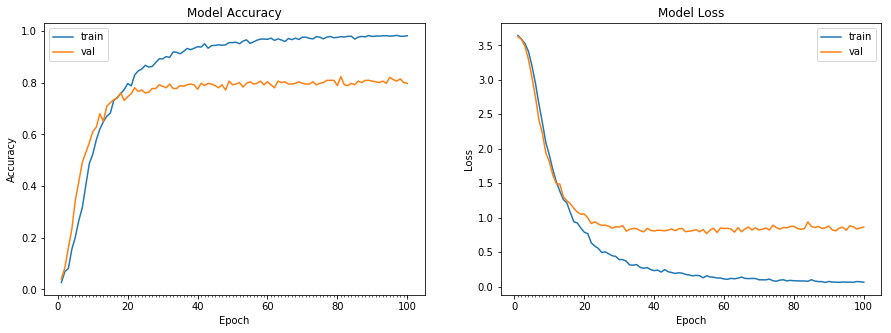

In [29]:
plot_model_history(history)

In [30]:
prediction1=model.predict(X_test)

In [31]:
prediction1

array([[1.5761739e-02, 7.9664057e-03, 2.9508477e-02, ..., 5.4087436e-01,
        8.2138984e-04, 3.6108613e-04],
       [2.9684727e-06, 6.2100333e-04, 3.0448844e-06, ..., 1.5281633e-07,
        1.8095585e-06, 5.0365902e-04],
       [1.0731497e-05, 1.8205629e-06, 5.8709078e-09, ..., 8.6063629e-08,
        1.1166121e-13, 1.8286560e-06],
       ...,
       [4.7349995e-03, 1.6434284e-06, 2.3532375e-03, ..., 4.1083592e-07,
        1.2166201e-08, 9.5200157e-03],
       [4.9177152e-06, 1.1349752e-06, 3.1660035e-01, ..., 4.8885075e-03,
        4.6213728e-01, 2.4507832e-05],
       [1.2899047e-03, 6.4270360e-05, 5.0170585e-03, ..., 1.8080916e-01,
        1.0282685e-03, 2.7090271e-03]], dtype=float32)

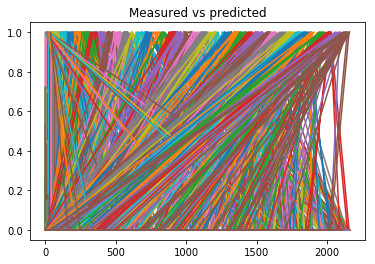

In [32]:
plt.plot(prediction1)
plt.plot(Y_test)
plt.title('Measured vs predicted')
plt.show()

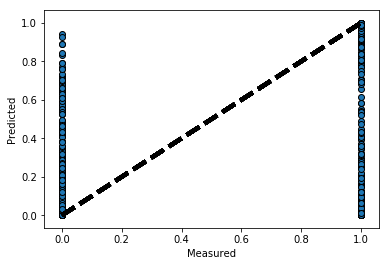

In [33]:
fig, ax = plt.subplots()
ax.scatter(Y_test, prediction1, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)# y max min values
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Overall classification accuracy and the confusion matrix

In [34]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [35]:
print ("Accuracy on test data is: %0.2f" %accuracy(np.array(X_test), np.array(Y_test), model))

Accuracy on test data is: 79.03


In [38]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [39]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 79.03%


In [41]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test) # this gives the probablities array
Y_pred_1 = np.where( Y_pred>0.5, 1, 0) # change to 1 if probality is greater than 0.5 otherwise 0
confusion_matrix_1 = confusion_matrix(np.array(Y_test).argmax(axis=1), Y_pred_1.argmax(axis=1))
print(confusion_matrix_1)

[[ 9  0  0 ...  0  0  0]
 [ 2  9  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 3  0  0 ...  6  0  0]
 [ 2  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0 13]]


Text(0.5,1,'Confusion matrix for CNN')

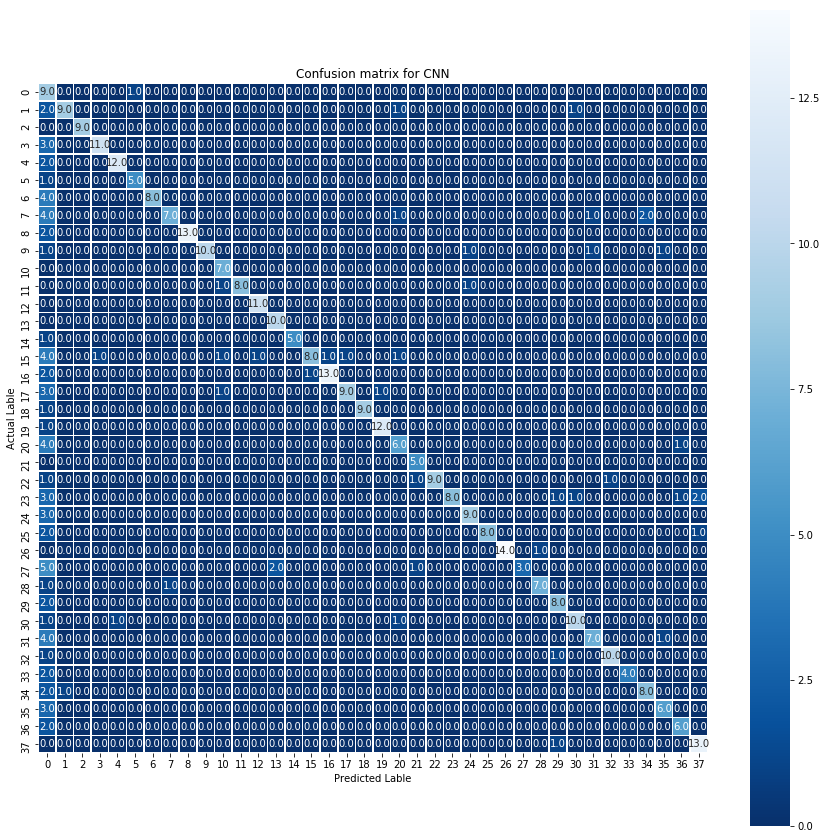

In [42]:
import seaborn as sns
plt.figure(figsize = (15,15))
sns.heatmap(confusion_matrix_1, annot= True, fmt = ".1f", linewidths= .5, square=True, cmap= 'Blues_r')
plt.ylabel('Actual Lable')
plt.xlabel('Predicted Lable')
plt.title('Confusion matrix for CNN')

## TASK 4: 

Make predictions on some image from test dataset by using the trained model and display the predicted class
and class probability on the image

In [44]:
# Predicted probablity values for the first two rows(images)
# Only two is taken for a space perpose and those two values for the problity are enogh to make the point
Y_pred[:2]

array([[1.57617386e-02, 7.96640571e-03, 2.95084771e-02, 6.33380250e-06,
        1.11044338e-02, 1.55260950e-01, 6.12479489e-05, 1.33063499e-04,
        1.37856667e-04, 4.92651621e-03, 1.23881595e-02, 2.97013728e-04,
        3.00317712e-04, 1.12826135e-02, 1.09418167e-03, 8.40071822e-04,
        1.35724503e-03, 5.15449443e-04, 2.95189098e-02, 5.47523203e-04,
        2.01291293e-02, 6.45078570e-02, 3.25191021e-02, 2.36946580e-04,
        1.06806714e-04, 2.03482062e-02, 6.35168701e-03, 4.42703633e-04,
        2.49265302e-02, 8.52303521e-04, 2.51222099e-03, 3.84039275e-04,
        3.82740200e-06, 3.76756798e-04, 1.23652490e-03, 5.40874362e-01,
        8.21389840e-04, 3.61086131e-04],
       [2.96847270e-06, 6.21003332e-04, 3.04488435e-06, 5.58558089e-10,
        6.53662141e-07, 2.58734472e-05, 1.02814788e-08, 4.13701055e-05,
        1.84272905e-03, 3.63198268e-07, 7.81196431e-05, 2.82554328e-03,
        7.87149656e-06, 7.15997430e-06, 1.60304303e-09, 7.64458790e-08,
        3.42540722e-03,

In [45]:
# Predicted probablity values chaged to binary values(1 for problablity value greater than 0.5, 0 other wise)
# for the first 5 value
Y_pred_1[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [47]:
# The class values for the first 5 values of the testing set
np.array(Y_test[0:5])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)